In [1]:
%matplotlib inline
from stack_nlp import *
from jupyter_mplsettings import *
matplotlib.rc('font', **font)

In [2]:
cfg = local_import("./default.py")

In [3]:
PrepareData(cfg)

Shape of question df (1696819, 21)
Shape of answer df (2028240, 21)
Loading word dictionary...
Warning! Dropping some words from word list, please verify!
Calculating normalized columns. They are available under usual column name + _norm.


In [4]:
data = cfg.data

In [5]:
data.keys()

['meta', 'dict', 'features', 'answers']

In [6]:
qs = data["meta"];

In [7]:
qs.head()
print qs.shape

(673622, 46)


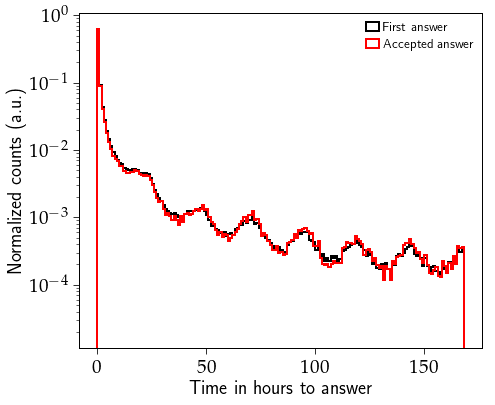

In [54]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Time in hours to answer")
plt.ylabel(r"Normalized counts (a.u.)")
plt.hist(qs.dt_answer_hour, range=[0, 7 * 24], bins=7 * 24, 
         histtype="step", lw=2, color="k", label="First answer", normed=True, log=True);
plt.hist(qs.dt_accanswer_hour, range=[0, 7 * 24], bins=7 * 24,
        histtype="step", lw=2, color="r", label="Accepted answer", normed=True, log=True);
# plt.semilogy(nonposy="clip")
plt.legend(loc="upper right");

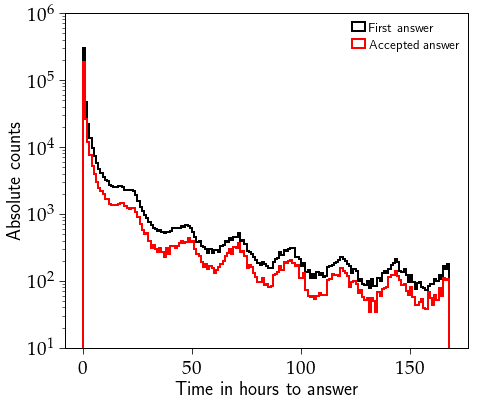

In [53]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Time in hours to answer")
plt.ylabel(r"Absolute counts")
plt.hist(qs.dt_answer_hour, range=[0, 7 * 24], bins=7 * 24, 
         histtype="step", lw=2, color="k", label="First answer", log=True);
plt.hist(qs.dt_accanswer_hour, range=[0, 7 * 24], bins=7 * 24,
        histtype="step", lw=2, color="r", label="Accepted answer", log=True);
# plt.semilogy(nonposy="clip")
plt.ylim(10, 10 ** 6)
plt.legend(loc="upper right")
plt.savefig("./plots/dthist_first_accepted.pdf")

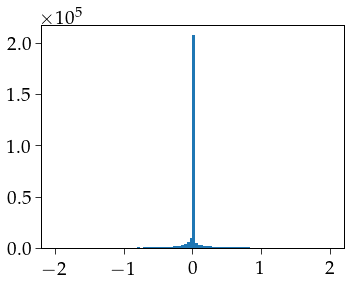

In [14]:
plt.hist(qs.dt_accanswer_hour - qs.dt_answer_hour, range=[-2, 2], bins=100);
# plt.semilogy(nonposy="clip")

In [15]:
print np.sum(~qs.dt_answer.isnull())
print np.sum(~qs.dt_accanswer.isnull())

536044
307514


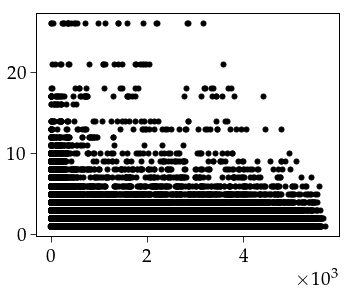

In [16]:
plt.plot(qs.dt_answer_hour, qs.AnswerCount, "k.")

In [142]:
qs.columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

[ 1.  4.]


stack_util.py:252: RuntimeWarning: divide by zero encountered in log10
  max(2 - np.floor(np.abs(np.log10(ztrafo(zedgs[i])))), 0), 2)


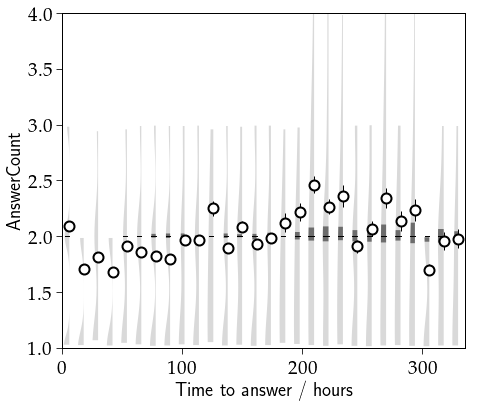

[ 0.  7.]


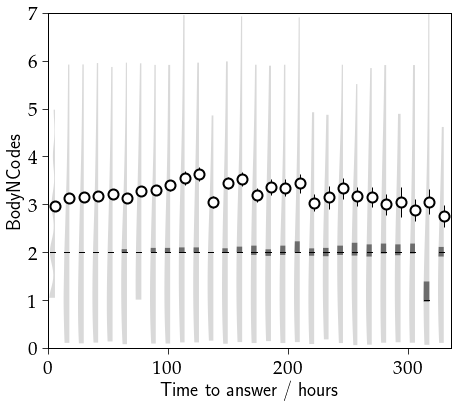

[ 0.  3.]


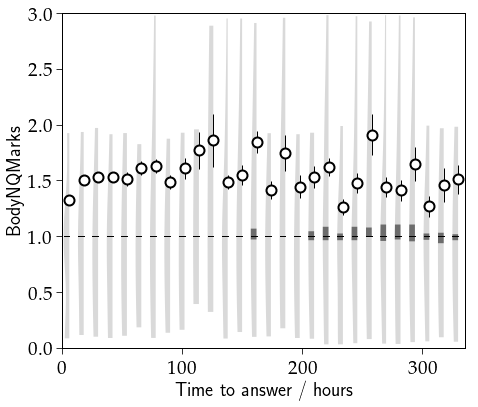

[  396.  3127.]


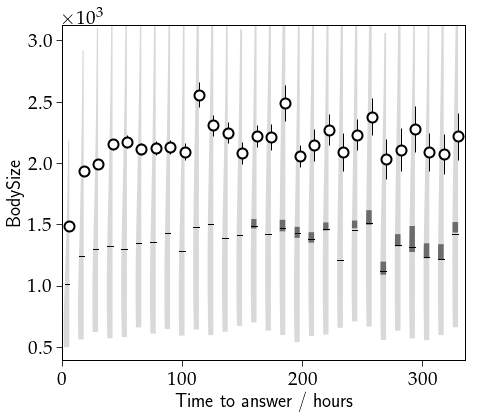

[ 31.  80.]


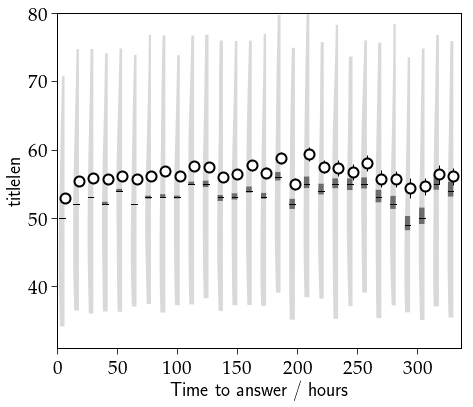

[ 14.  74.]


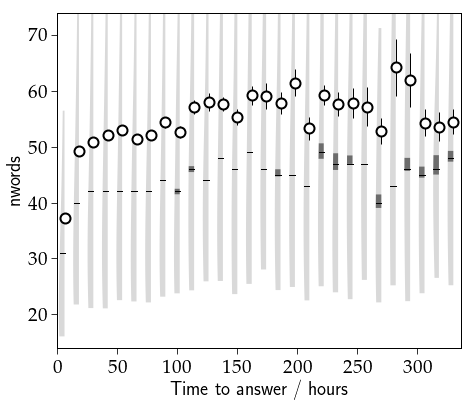

[  2974.  23345.]


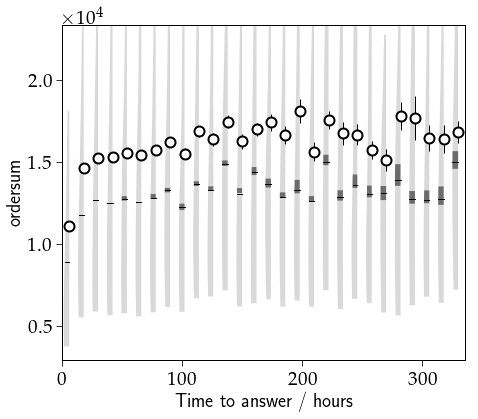

[ 0.26086957  0.88235294]


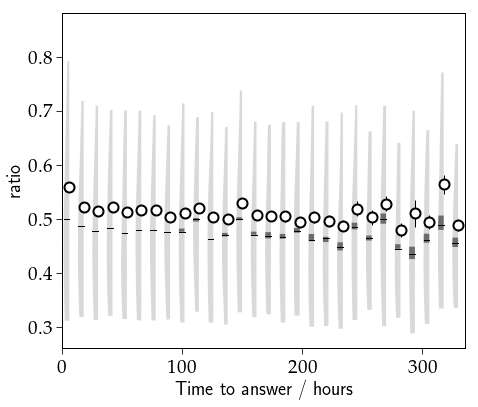

[ 0.  2.]


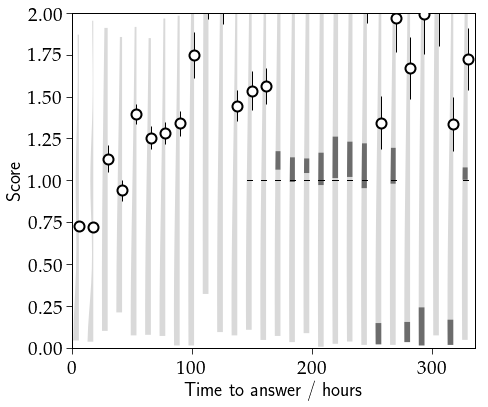

[  2.23909674e-54   3.09808260e-18]


RuntimeError: LaTeX was not able to process the following string:
'prob_bern'

Here is the full report generated by LaTeX:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Arch Linux) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./cd195535965d82d886be4415d5f8e1dc.tex
LaTeX2e <2017-04-15>
Babel <3.12> and hyphenation patterns for 84 language(s) loaded.
(/usr/share/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf-dist/tex/latex/psnfss/mathpazo.sty)
(/usr/share/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texmf-dist/tex/latex/ucs/ucs.sty
(/usr/share/texmf-dist/tex/latex/ucs/data/uni-global.def))
(/usr/share/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texmf-dist/tex/latex/ucs/utf8x.def))
(/usr/share/texmf-dist/tex/latex/siunitx/siunitx.sty
(/usr/share/texmf-dist/tex/latex/l3kernel/expl3.sty
(/usr/share/texmf-dist/tex/latex/l3kernel/expl3-code.tex)
(/usr/share/texmf-dist/tex/latex/l3kernel/l3dvips.def))
(/usr/share/texmf-dist/tex/latex/l3packages/xparse/xparse.sty)
(/usr/share/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texmf-dist/tex/latex/tools/array.sty)
(/usr/share/texmf-dist/tex/latex/l3packages/l3keys2e/l3keys2e.sty)
(/usr/share/texmf-dist/tex/latex/beamer/translator/translator.sty
(/usr/share/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texmf-dist/tex/latex/beamer/translator/translator-language-mappings
.tex))) (/usr/share/texmf-dist/tex/latex/tools/xspace.sty)
(/usr/share/texmf-dist/tex/latex/amsfonts/amssymb.sty
(/usr/share/texmf-dist/tex/latex/amsfonts/amsfonts.sty))
(/usr/share/texmf-dist/tex/latex/mathcomp/mathcomp.sty)
(/usr/share/texmf-dist/tex/latex/units/nicefrac.sty
(/usr/share/texmf-dist/tex/latex/base/ifthen.sty))
(/usr/share/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file cd195535965d82d886be4415d5f8e1dc.aux.
(/usr/share/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/share/texmf-dist/tex/latex/psnfss/ot1ppl.fd)
(/usr/share/texmf-dist/tex/latex/ucs/ucsencs.def)
(/usr/share/texmf-dist/tex/latex/beamer/translator/dicts/translator-basic-dicti
onary/translator-basic-dictionary-English.dict)
(/usr/share/texmf-dist/tex/latex/siunitx/siunitx-abbreviations.cfg)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(/usr/share/texmf-dist/tex/latex/psnfss/omlzplm.fd)
(/usr/share/texmf-dist/tex/latex/psnfss/omszplm.fd)
(/usr/share/texmf-dist/tex/latex/psnfss/omxzplm.fd)
(/usr/share/texmf-dist/tex/latex/psnfss/ot1zplm.fd)
! Missing $ inserted.
<inserted text> 
                $
l.43 ...size{19.200000}{24.000000}{\sffamily prob_
                                                  bern}

LaTeX Font Warning: Font shape `TS1/cmr/m/n' in size <19.2> not available
(Font)              size <20.74> substituted on input line 43.


LaTeX Font Warning: Font shape `TS1/cmr/m/n' in size <11.52011> not available
(Font)              size <12> substituted on input line 43.

! Extra }, or forgotten $.
l.43 ...19.200000}{24.000000}{\sffamily prob_bern}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.44 \end{document}
                   
[1] (./cd195535965d82d886be4415d5f8e1dc.aux)

LaTeX Font Warning: Size substitutions with differences
(Font)              up to 1.54001pt have occurred.

 )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 43 ({)
### bottom level
(see the transcript file for additional information)
Output written on cd195535965d82d886be4415d5f8e1dc.dvi (1 page, 364 bytes).
Transcript written on cd195535965d82d886be4415d5f8e1dc.log.
 



In [18]:
qs.columns
m = np.isfinite(qs.dt_accanswer_hour)

ndays = 14
# dthours = qs.dt_answer.dt.total_seconds() * 1. / 3600
cols = ["AnswerCount", "BodyNCodes", "BodyNQMarks", "BodySize", "titlelen", "nwords", "ordersum", "ratio", "Score", "prob_bern"]
# f, axarr = plt.subplots(2, 4, squeeze=False)
for i, col in enumerate(cols):
    quants = mquantiles(qs[m][col], prob=[0.1, 0.9])
    print quants
    plt.figure(i, figsize=(8, 6))
    plt.xlabel(r"Time to answer / hours")
    plt.ylabel(r"%s" % col)
#     plt.plot(dthours, qs[col], "k.")
    QuickSlicePlot(qs.dt_accanswer_hour[m], qs[m][col], qs.dt_accanswer_hour[m], zbins=1, yrange=quants, 
                   xRange=[0, ndays * 24], xbins=2 * ndays, draw="amvs",
                   axes=plt.gca())
    plt.xlim(0, ndays * 24)
    plt.show()
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
# plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
# plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

In [141]:
qs["dayhour"] = qs.CreationDate.dt.hour
qs["weekday"] = qs.CreationDate.dt.dayofweek
# training and testing samples
qs = shuffle(qs)
print len(qs)
# limiting to questions with accepted answer for training
qsgood = qs[~qs.dt_accanswer.isnull()]
# for training, consider only first weeks for answer time (due to reweighting)
qsgood = qsgood[qsgood.dt_accanswer_hour <= 14 * 24]
qsgood = qsgood[qsgood.dt_accanswer_hour > 0]
print len(qsgood)
train = 200000
qstrain = qsgood.iloc[:train]
qstest = qsgood.iloc[train:]
print len(qstrain)
print len(qstest)

label = "dt_accanswer_hour"

# sample with no answers, aka the ultimate testing sample
qsnone = qs[qs.AnswerCount == 0]
print len(qsnone)

AttributeError: 'numpy.ndarray' object has no attribute 'CreationDate'

In [129]:
# we probably want to reweight events according to the steeply falling time distribution...
#max(qstrain.dt_accanswer_hour)
# counts, edges = np.histogram(qstrain.dt_accanswer_hour, mquantiles(qstrain.dt_accanswer_hour, prob=np.linspace(0., 1., 100)))
from pyik.numpyext import centers

counts, edges = np.histogram(np.log(qstrain.dt_accanswer_hour), bins=300)
cens = centers(edges)[0]
counts = counts * 1. / np.sum(counts) * np.e ** cens
counts;
print edges[:10];
weights = 1. / counts[np.minimum(np.digitize(np.log(qstrain.dt_accanswer_hour.values), edges) - 1, len(counts) - 1)]
print qstrain.dt_accanswer_hour.iloc[:10]
print weights[:10]
qstrain["weights"] = weights

[-5.56855253 -5.53060045 -5.49264837 -5.4546963  -5.41674422 -5.37879214
 -5.34084007 -5.30288799 -5.26493592 -5.22698384]
165393      9.570600
594158     19.380192
635274      0.320520
536577      0.305832
650726    119.093568
448835      5.051976
462553      0.015240
303380      0.553632
6371        0.077760
202143      0.043056
Name: dt_accanswer_hour, dtype: float64
[  4.32895266e+01   1.54589947e+01   3.84747675e+02   3.89633567e+02
   4.13285842e+00   7.51366525e+01   4.23109881e+05   2.48391725e+02
   1.88735321e+03   7.93845491e+03]


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [140]:
qstrain.columns

Index([u'AcceptedAnswerId', u'AnswerCount', u'BodyNCodes', u'BodyNQMarks',
       u'BodySize', u'ClosedDate', u'CommentCount', u'CommunityOwnedDate',
       u'CreationDate', u'FavoriteCount', u'Id', u'LastActivityDate',
       u'LastEditDate', u'LastEditorUserId', u'OwnerUserId', u'ParentId',
       u'PostTypeId', u'Score', u'Tags', u'Title', u'ViewCount', u'titlelen',
       u'hasAnswers', u'dt_created', u'Id_r', u'hot_indices', u'nwords',
       u'ordersum', u'prob_bern', u'prob_poiss', u'ratio', u'ParentId_first',
       u'CreationDate_first', u'Id_acc', u'CreationDate_acc', u'dt_answer',
       u'dt_accanswer', u'dt_answer_hour', u'dt_accanswer_hour',
       u'BodyNCodes_norm', u'BodyNQMarks_norm', u'BodySize_norm',
       u'titlelen_norm', u'nwords_norm', u'ordersum_norm', u'ratio_norm',
       u'weights'],
      dtype='object')

In [62]:
import dill
# dill.dump(estimator, open('estimator.dill', 'w'))
# estimator = dill.load(open('estimator.dill', 'r'))

## Fitting random forest to the space of simple features derived from the text

In [101]:
cols = [col for col in qstrain.columns if "_norm" in col]

['BodyNCodes_norm',
 'BodyNQMarks_norm',
 'BodySize_norm',
 'titlelen_norm',
 'nwords_norm',
 'ordersum_norm',
 'ratio_norm']

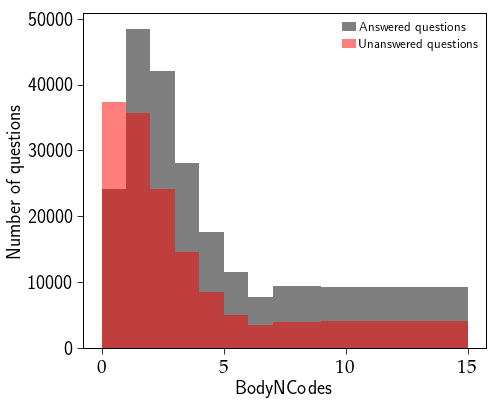

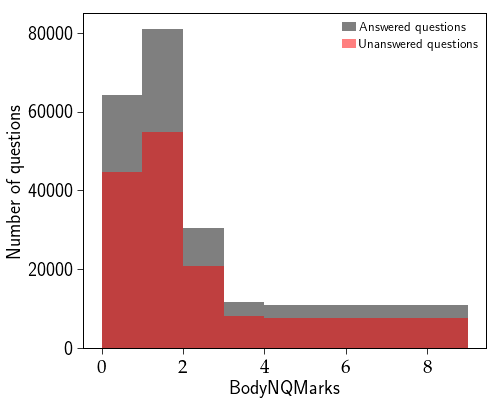

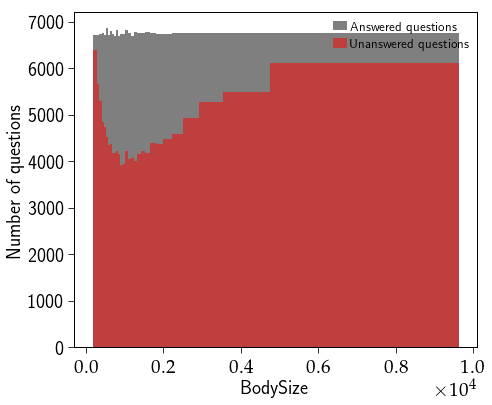

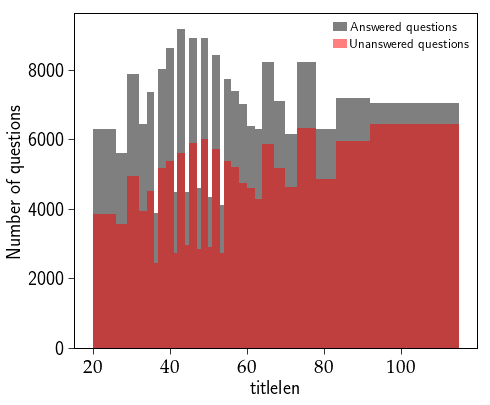

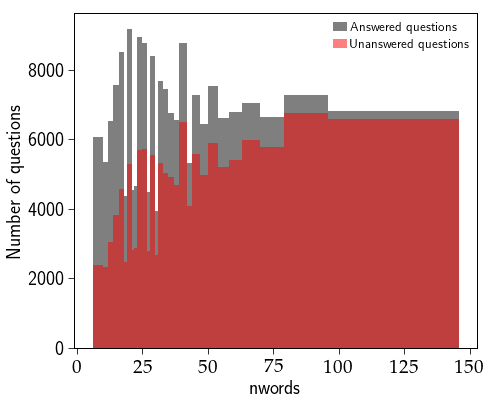

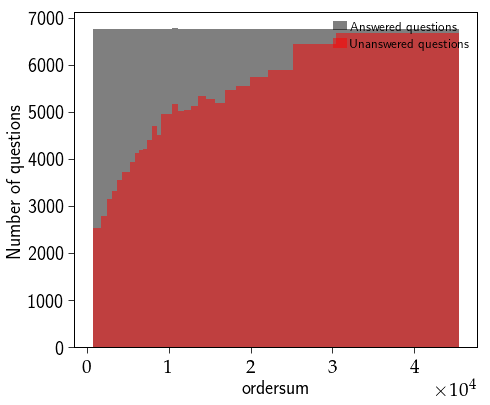

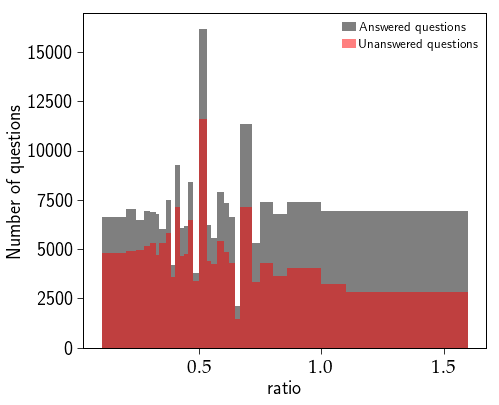

In [122]:
for col in cols:
    cvals = qstrain[col]
    qs = mquantiles(cvals, prob=np.linspace(0.01, 0.99, 30))
    plt.figure(figsize=(8, 6))
    plt.ylabel(r"Number of questions")
    plt.xlabel(col)
    plt.hist(qstrain[col], bins=qs, color="k", histtype="stepfilled", alpha=0.5, lw=2, label="Answered questions")
    plt.hist(qsnone[col], bins=qs, color="r", histtype="stepfilled", alpha=0.5, lw=2, label="Unanswered questions")
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%.0f"))
    plt.legend(loc="best")

In [130]:
pipe_feat_fct = lambda a: Pipeline([
         ("cst", ColumnSelectTransformer([col for col in qstrain.columns if "_norm" in col] + ["weekday", "dayhour"])),
         ("poly", PolynomialFeatures(degree=3)),
         ("ridge", Ridge(alpha=a, normalize=True))
#          ("multi", MultiModelRegressor(Ridge(alpha=a, normalize=True), RandomForestRegressor(n_estimators=20)))
#          ("ranforest", RandomForestRegressor(n_estimators=15))
    ])

pipe_feat = pipe_feat_fct(2)

In [ ]:
cv = model_selection.ShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
def compute_error(est, X, y):
    return -model_selection.cross_val_score(est, X, y, cv=cv, scoring='neg_mean_squared_error').mean()

for alpha in np.linspace(0.1, 10, 20):
    pipe = pipe_feat_fct(alpha)
    pipe.fit(qstrain, np.log(qstrain[label]))
    print alpha, compute_error(pipe, qstrain, np.log(qstrain[label]))

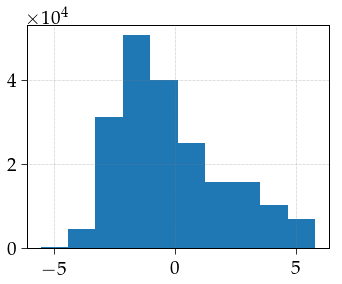

In [112]:
np.log(qstrain[label]).hist()

In [134]:
# weighted ridge regression
pipe_feat.fit(qstrain, qstrain[label], **{"ridge__sample_weight": qstrain.weights})
# pipe_feat.fit(qstrain, np.log(qstrain[label]))
pred = pipe_feat.predict(qstest)
print np.column_stack((pred, np.log(qstest[label])))
print pipe_feat.score(qstest, np.log(qstest[label]))
# print pipe_feat.score(qstest, np.log(qstest[label]), sample_weight=qstest.weights)

[[ 0.0430973   0.14584428]
 [ 0.069517    1.23676598]
 [ 0.04668161  1.61847218]
 ..., 
 [ 0.11879871 -0.07066284]
 [ 0.08686244 -3.37693413]
 [ 0.31672581 -1.75673215]]
-0.130109219528


In [109]:
pipe_tags = Pipeline([
                     ("cst", ColumnSelectTransformer(["Tags"])),
                     ("dec", DictEncoder("Tags")),
                     ("dvec", DictVectorizer(sparse=True)),
                     ("tfid", TfidfTransformer()),
                     # ("poly", PolynomialFeatures(degree=2)),  # not working???
                     ("ridge", Ridge(alpha=2.0))
                     # ("kridge", KernelRidge(alpha=1.))  # runs out of memory quickly while fitting...
                     # ("svr", SVR())
                     ])

pipe_tags.fit(qstrain, np.log(qstrain[label]))
pred = pipe_tags.predict(qstest)
print np.column_stack((pred, np.log(qstest[label])))
print pipe_tags.score(qstest, np.log(qstest[label]))

[[ 0.00511659  1.9665494 ]
 [-1.08613435 -2.20017292]
 [-0.98256895  0.59103472]
 ..., 
 [ 0.50562342  2.8876788 ]
 [ 0.3175562   0.8324986 ]
 [-0.81560621 -3.01577173]]
0.25142441609


In [111]:
pipe_words = Pipeline([
                      ("cst", ColumnSelectTransformer(["hot_indices"])),
                      ("dec", DictEncoder("hot_indices")),
                      ("dvec", DictVectorizer(sparse=True)),
                      ("tfid", TfidfTransformer()),
#                       ("ridge", Ridge(alpha=2.0))
                      ("mlp", MLPRegressor(hidden_layer_sizes=(100,)))
                      ])

pipe_words.fit(qstrain, np.log(qstrain[label]))
pred = pipe_words.predict(qstest)
print np.column_stack((pred, np.log(qstest[label])))
print pipe_words.score(qstest, np.log(qstest[label]))

[[-0.37112969  1.9665494 ]
 [-0.25269353 -2.20017292]
 [ 0.17736415  0.59103472]
 ..., 
 [ 0.6041694   2.8876788 ]
 [-0.1422461   0.8324986 ]
 [ 0.48070226 -3.01577173]]
0.0440072331811


In [ ]:
union = FeatureUnion([
                     ("tags", EstimatorTransformer(pipe_tags)),
                     ("words", EstimatorTransformer(pipe_words)),
                     ("feat", EstimatorTransformer(pipe_feat))
                     ])

pipe_all = Pipeline([
                    ("union", union),
                    ("ridge", Ridge(alpha=3.0))
                    # ("comb", CustomCombiner())
                    ])

pipe_combined.fit(qstrain, np.log(qstrain[label]))
pred = pipe_combined.predict(qstest)
print np.column_stack((pred, np.log(qstest[label])))
print pipe_combined.score(qstest, np.log(qstest[label]))

In [27]:
import dill

In [104]:
dill.dump(pipe_feat, open("pipe_feat.dill", "w"))

In [24]:
pipe_feat = dill.load(open('pipe_feat.dill', 'r'))

/usr/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator PolynomialFeatures from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator Ridge from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)

## Investigating difference (residuals) in test sample vs. various dimensions

In [135]:
predtimes = np.e ** pred

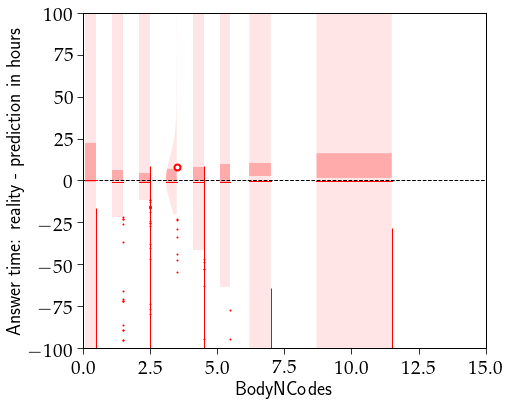

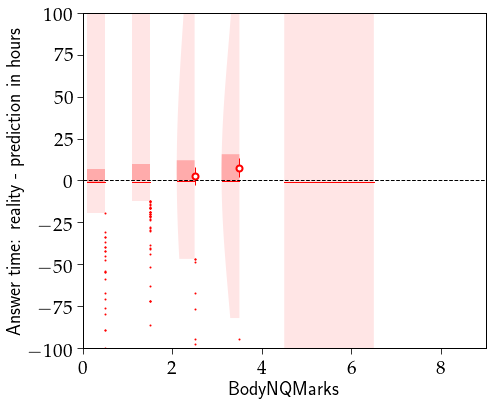

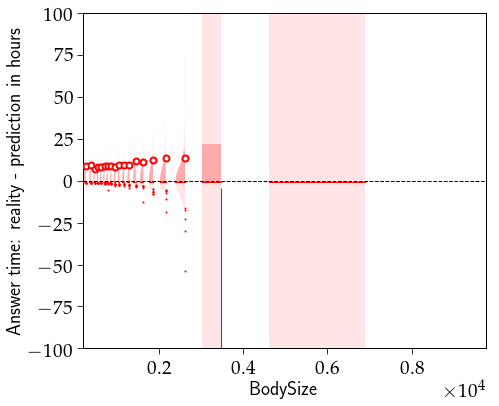

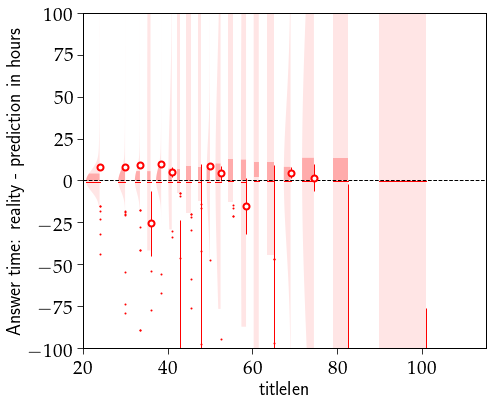

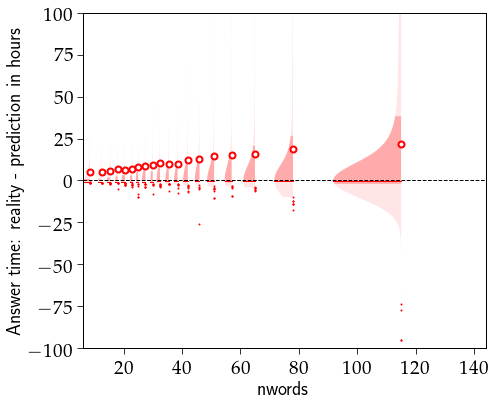

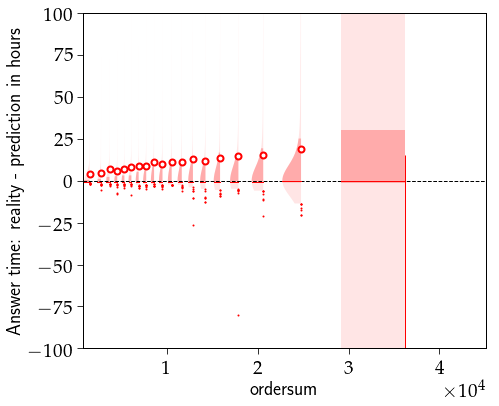

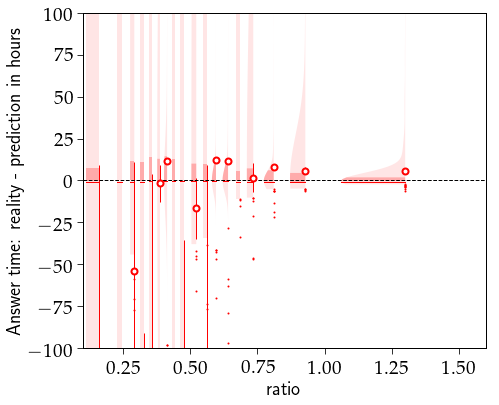

In [136]:
cols = [col.replace("_norm", "") for col in qstrain.columns if "_norm" in col]
diff = qstest[label] - predtimes

for i, col in enumerate(cols):
    yquants = mquantiles(diff, prob=[0.05, 0.95])
    xquants = mquantiles(qstest[col], prob=np.linspace(0.01, 0.99, 20))
    plt.figure(i, figsize=(8, 6))
    plt.xlabel("%s" % col)
    plt.ylabel(r"Answer time: reality - prediction in hours")
    QuickSlicePlot(qstest[col], diff, qstest.dt_accanswer_hour, zbins=1, yrange=yquants, 
                   xbins=xquants, draw="amv", color="red", ms=6,
                   axes=plt.gca())
    plt.axhline(0, lw=1, ls="--", color="k")
    plt.ylim(-100, 100)
    plt.xlim(min(xquants), max(xquants))
    plt.show()

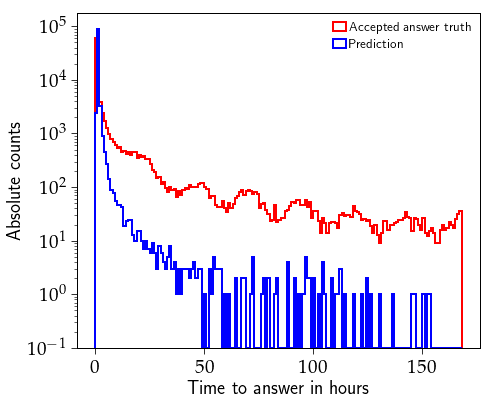

In [138]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Time to answer in hours")
plt.ylabel(r"Absolute counts")
plt.hist(qstest.dt_answer_hour, range=[0, 7 * 24], bins=7 * 24, 
         histtype="step", lw=2, color="r", label="Accepted answer truth", log=True);
plt.hist(predtimes, range=[0, 7 * 24], bins=7 * 24,
        histtype="step", ls="-", lw=2, color="b", label="Prediction", log=True);
# plt.semilogy(nonposy="clip")
plt.legend(loc="upper right");

(0, 168)

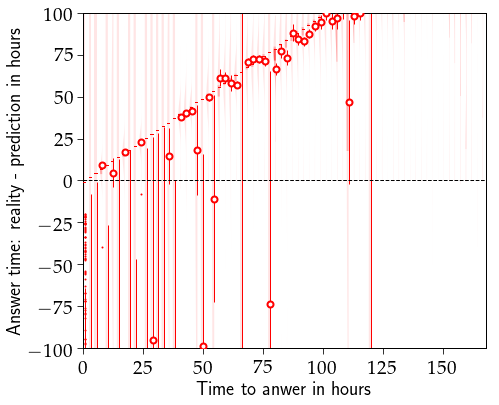

In [139]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Time to anwer in hours")
plt.ylabel(r"Answer time: reality - prediction in hours")
QuickSlicePlot(qstest.dt_answer_hour, diff, qstest.dt_accanswer_hour, zbins=1, yrange=[-50, 50], 
               xRange=[0, 7 * 24], xbins=3 * 24, draw="amv", color="red", ms=6,
               axes=plt.gca())
plt.axhline(0, lw=1, ls="--", color="k")
plt.ylim(-100, 100)
plt.xlim(0, 7 * 24)

## effect of the number of questions per time (more questions -> more answer delay?)

In [58]:
# number of 
date_edges = pd.date_range(qstrain.CreationDate.min(), qstrain.CreationDate.max(), freq="H")
# print date_edges
date_centers = date_edges[:-1] + (date_edges[1:] - date_edges[:-1]) / 2
date_centers = date_centers.to_pydatetime()
# print date_centers
allcounts = pd.cut(qstrain.CreationDate, bins=date_edges).value_counts().values[::-1]

In [62]:
allcounts.shape
date_edges.shape

(1716,)

In [ ]:
qstrain

In [88]:
print qstrain.shape
# doing it with groupby...more elegant
qrate = qstrain.groupby([qstrain.CreationDate.dt.year, qstrain.CreationDate.dt.month, 
                         qstrain.CreationDate.dt.day, qstrain.CreationDate.dt.hour]).size()

(200000, 46)


In [90]:
qstrainmulti = qstrain.set_index([qstrain.CreationDate.dt.year, qstrain.CreationDate.dt.month, 
                                  qstrain.CreationDate.dt.day, qstrain.CreationDate.dt.hour])
qstrainmulti["qrate"] = qrate
qstrain = qstrainmulti.reset_index(drop=True)
print qstrain.shape

(200000, 47)


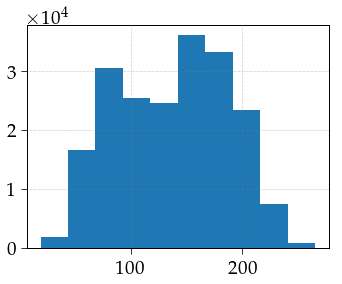

In [96]:
qstrain.qrate.hist()

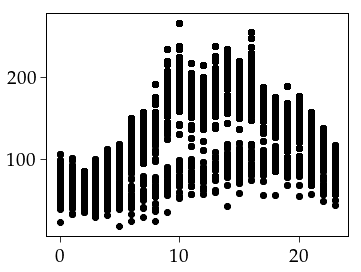

In [98]:
plt.plot(qstrain.CreationDate.dt.hour, qstrain.qrate, "k.")

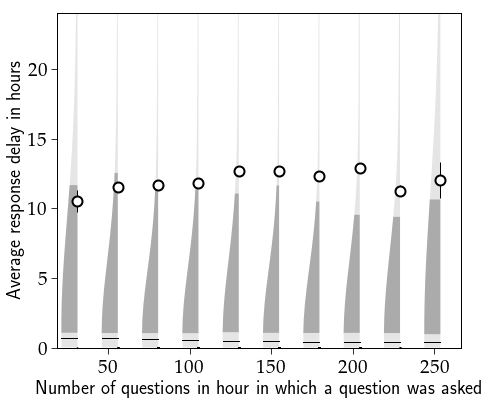

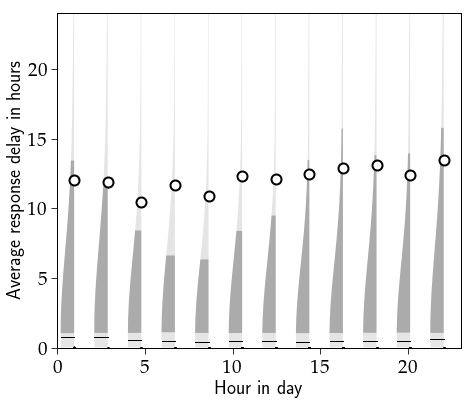

In [99]:
# dependence of average answer delay with the rate of questions in the same hour of asking a particular question
plt.figure(figsize=(8, 6))
plt.xlabel("Number of questions in hour in which a question was asked")
plt.ylabel("Average response delay in hours")
QuickSlicePlot(qstrain.qrate, qstrain.dt_accanswer_hour, qstrain.Score, zbins=1, xbins=10,
              yrange=[0, 24], draw="amv", axes=plt.gca())
plt.show()

# dependence of average answer delay with the rate of questions in the same hour of asking a particular question
plt.figure(figsize=(8, 6))
plt.xlabel("Hour in day")
plt.ylabel("Average response delay in hours")
QuickSlicePlot(qstrain.CreationDate.dt.hour, qstrain.dt_accanswer_hour, qstrain.Score, zbins=1, xbins=12,
              yrange=[0, 24], draw="amv", axes=plt.gca())
plt.show()